In [3]:
# Import libraries
import os
import math
import glob
import json
import torch
import string
import random
import unicodedata

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from io import open
from tqdm import tqdm
from torch import optim
from pathlib import Path
from transformers import AdamW
from transformers import GPT2Config
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import  AutoModelForCausalLM
from __future__ import unicode_literals, print_function, division

# Part A & B

In [4]:
# Define a dataset class
class PoemDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=35):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.poems = self.load_poems(file_path)

    def load_poems(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            poems = file.readlines()
        return poems

    def __len__(self):
        # Ensure the dataset size is even, as we're pairing odd and even sequences
        return len(self.poems) // 2

    def tokenize_poem(self, poem):
        return self.tokenizer('<s>' + poem + '</s>', return_tensors="pt", padding="max_length", max_length=self.max_length)

    def __getitem__(self, idx):
        # Pair odd and even sequences
        odd_poem = self.poems[idx * 2].strip()
        even_poem = self.poems[idx * 2 + 1].strip()

        # Tokenize input odd poem
        input_odd = self.tokenize_poem(odd_poem)
        input_odd_labels = self.tokenize_poem(odd_poem)

        # Tokenize even poem for labels
        labels_even = self.tokenize_poem(even_poem)

        return {"input_ids": input_odd["input_ids"], "labels": labels_even["input_ids"], "attention_mask":torch.ones_like(input_odd["input_ids"])}

# Load tokenizer
model_name = "HooshvareLab/gpt2-fa"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
    unk_token='<unk>')

# Load Ferdousi poems for fine tuning
file_path = '/kaggle/input/poemssss/ferdousi.txt'
poem_dataset = PoemDataset(file_path=file_path, tokenizer=tokenizer, max_length=35)


# Split the dataset into train and test sets
train_size = int(0.8 * len(poem_dataset))
test_size = len(poem_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(poem_dataset, [train_size, test_size])

# DataLoader batch size setup
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/875k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

In [5]:
print('Number of pairs(BEYTs):',len(poem_dataset))
print('=' * 50)

# Print a sample datapoint
print('Input::',tokenizer.decode(poem_dataset.__getitem__(4960)['input_ids'].squeeze()))
print('Label::',tokenizer.decode(poem_dataset.__getitem__(4960)['labels'].squeeze()))
print('=' * 50)

Number of pairs(BEYTs): 49608
Input:: <s>چنان ساخت روشن جهان آفرین</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Label:: <s>که پنهان نکرد اژدها را زمین</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [6]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sun Jan  7 18:20:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Part C

In [7]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Load GPT-2 Farsi model and move to Device
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

pytorch_model.bin:   0%|          | 0.00/485M [00:00<?, ?B/s]

In [8]:
# Set optimizer
optimizer = AdamW(model.parameters(), lr=5e-4, eps=1e-8)

# Set number of epochs
num_epochs = 4

# Loss lists for plot
train_loss = []
validation_loss = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        inputs = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        b_masks = batch["attention_mask"].to(device)

        optimizer.zero_grad()
        model.zero_grad()
        outputs = model(inputs, labels=labels, attention_mask=b_masks)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    train_loss.append(average_loss)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")

    # Validation loop
    
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validation"):
            inputs = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            b_masks = batch["attention_mask"].to(device)

            outputs = model(inputs, labels=labels, attention_mask=b_masks)
            loss = outputs.loss

            total_test_loss += loss.item()

    average_test_loss = total_test_loss / len(test_dataloader)
    validation_loss.append(average_test_loss)
    print(f"Average Validation Loss: {average_test_loss}")

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 311/311 [03:13<00:00,  1.61it/s]


Epoch 1, Average Loss: 1.5959391053466552


Validation: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Average Validation Loss: 1.4389127355355482


Epoch 2: 100%|██████████| 311/311 [03:12<00:00,  1.61it/s]


Epoch 2, Average Loss: 1.4148794623433203


Validation: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Average Validation Loss: 1.4123997214512947


Epoch 3: 100%|██████████| 311/311 [03:12<00:00,  1.61it/s]


Epoch 3, Average Loss: 1.3685466675896354


Validation: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Average Validation Loss: 1.3965735466052325


Epoch 4: 100%|██████████| 311/311 [03:12<00:00,  1.62it/s]


Epoch 4, Average Loss: 1.3202510443531048


Validation: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]

Average Validation Loss: 1.4020713109236498


In [8]:
# Clear cache
torch.cuda.empty_cache()

#### As you see the model will be overfitted after 4th epoch,so I just trained for 4 epoch.

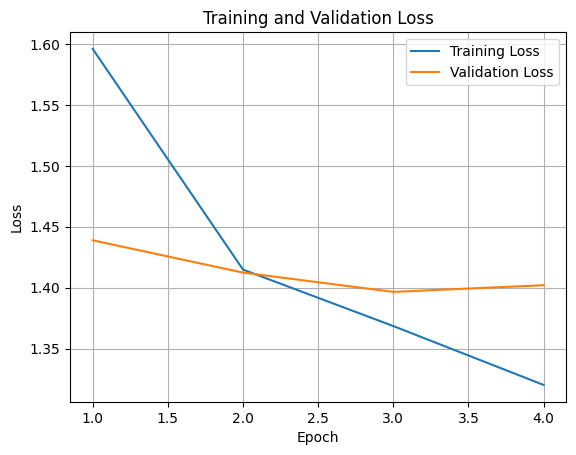

In [10]:
# A Function for plot loss
def plot_loss(train_losses, val_losses, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    plt.show()

# Call the function to plot the loss
plot_loss(train_loss, validation_loss, num_epochs)

# Part D

### Generate a Poem with random prompts, you can generate your poem with following function!

In [39]:
def generate_poem(model, tokenizer, prompt, max_length=15, top_k=1):
    nl_index = len(prompt)
    input_ids = tokenizer.encode('<s>' + prompt + '</s>', return_tensors="pt").to(device)
#     print(input_ids)
#     print('-------------------------------')
#     input_ids = tokenizer('<s>' + prompt + '</s>', return_tensors="pt", padding="max_length", max_length=35).to(device)
#     print(input_ids)
#     print('------------------------------')
    
    model.eval()
    
    # Generate poem
    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_length, num_beams=15, no_repeat_ngram_size=1, top_k=top_k,
                                attention_mask=torch.ones_like(input_ids),
#                                 eos_token_id=tokenizer.eos_token_id,
                                pad_token_id=tokenizer.pad_token_id,)
#                                 bos_token_id=tokenizer.bos_token_id)

    generated_poem = tokenizer.decode(output[0] , skip_special_tokens = True)
    final_poem = final_gen = '\n' +generated_poem[:nl_index] + '\n' + generated_poem[nl_index:]
    print('----------------------------------')
    return final_poem

In [42]:
print(generate_poem(model, tokenizer, 'به نام خداوند'))
print(generate_poem(model, tokenizer, 'دافی که میزنم باید موی'))
print(generate_poem(model, tokenizer, 'رو تابلوی جاده نوشته شمشک'))
print(generate_poem(model, tokenizer, 'من تنهام مثل ماهی توی تنگ'))
print(generate_poem(model, tokenizer, 'بسی رنج بردم'))
print(generate_poem(model, tokenizer, 'نمره کامل بده آرشاک لطفا '))
print(generate_poem(model, tokenizer, 'گناه دارم'))
print(generate_poem(model, tokenizer, 'بسی رنج بردم زین تمرین'))
print(generate_poem(model, tokenizer, 'توانا بود'))

----------------------------------

به نام خداوند
 ماه و دستگاه تاج عاجاج گنج رنج تخت
----------------------------------

دافی که میزنم باید موی
 روی جوی بوی اویویدیو
----------------------------------

رو تابلوی جاده نوشته شمشک
 رنج گنجنجگنجست بود
----------------------------------

من تنهام مثل ماهی توی تنگ
 درنگنگ جنگ چنگ ننگ
----------------------------------

بسی رنج بردم
 خون آوی ریختندآمیختندندگریگرانز
----------------------------------

نمره کامل بده آرشاک لطفا 
ادواد بادبادداد
----------------------------------

گناه دارم
 و رنج من تو مباد یاد بادواد داد
----------------------------------

بسی رنج بردم زین تمرین
 تنگنگ چنگ درنگ جنگ ننگم
----------------------------------

توانا بود
 از و به بر کموردردبم


### In following cell I generate the 2nd MESRA for each MESRA of the test set (I just print 40 of them).

In [37]:
def generate_poem(model, tokenizer, prompt, max_length=20,  top_k=1):
    
    # Decode the prompt
    input_ids = tokenizer.encode( '<s>' + prompt, return_tensors="pt").to(device)

    # Generate poem
    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_length,  top_k=top_k, num_beams=15, no_repeat_ngram_size=1, 
                                 attention_mask=torch.ones_like(input_ids),
#                                 eos_token_id=tokenizer.eos_token_id,
                                pad_token_id=tokenizer.pad_token_id, )
#                                 bos_token_id=tokenizer.bos_token_id)

    generated_poem = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_poem

# A function for pass the test data points (1st MESRA) to model and generate 2nd MESRA
def generate_poems_for_test_set(model, tokenizer, test_dataloader):
    model.eval()

    generated_poems = []
    
    for batch in tqdm(test_dataloader, desc="Generating Poems"):
        inputs = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        flag = 0
        for i in range(len(inputs)):
            flag+=1
            input_prompt = tokenizer.decode(inputs[i].squeeze(), skip_special_tokens=True)

            label = tokenizer.decode(labels[i].squeeze(), skip_special_tokens=True)

            generated_poem = generate_poem(model, tokenizer, input_prompt)
            generated_poems.append((input_prompt, generated_poem, label))
            if flag ==40:
                break
        break
    return generated_poems


# Generate poems for the test set
generated_poems = generate_poems_for_test_set(model, tokenizer, test_dataloader)

# Print generated poems
for input_prompt, generated_poem, label in generated_poems:
    print("")
    print(f"Input Prompt: \n {input_prompt}")
    nl_index = len(input_prompt)
    final_gen = '\n' +generated_poem[:nl_index] + '\n' + generated_poem[nl_index:]
    print('-------------------')
    print(f"Generated Poem: {final_gen}")
    print('-------------------')
    print(f"Label: \n {label}")
    print("=" * 50)

Generating Poems:   0%|          | 0/78 [00:07<?, ?it/s]


Input Prompt: 
 فراوان به درویش دینار داد
-------------------
Generated Poem: 
فراوان به درویش دینار داد
 شاداد بادوادبادداد نهادنهاد یادزاند
-------------------
Label: 
 همان خوردنیهای بسیار داد

Input Prompt: 
 که او را بود زندگانی دراز
-------------------
Generated Poem: 
که او را بود زندگانی دراز
 نیاز باز راز نازازبربم فرازت نماز
-------------------
Label: 
 نشیند به شادی و آرام و ناز

Input Prompt: 
 ز چیزی که گفتند پیغمبران
-------------------
Generated Poem: 
ز چیزی که گفتند پیغمبران
 ورندکهببرسرگرانمجهانان
-------------------
Label: 
 همان دادگر موبدان و ردان

Input Prompt: 
 همی شد گریزان تژاو دلیر
-------------------
Generated Poem: 
همی شد گریزان تژاو دلیر
 شیریر سیر زیربرسرازبدب
-------------------
Label: 
 پسش بیژن گیو برسان شیر

Input Prompt: 
 یکی لشکر آمد بر ما به جنگ
-------------------
Generated Poem: 
یکی لشکر آمد بر ما به جنگ
 درنگ ننگ تنگنگمزبغ پلنگ چنگ
-------------------
Label: 
 چو کلباد و نستیهن تیز چنگ

Input Prompt: 
 به ازبنده بندن بسال دراز
--------------

### BLEU and Perplexity

In [ ]:
# Define a function to calculate perplexity
def calculate_perplexity(model, iterator, criterion):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch.src.to(device)
            trg = batch.trg.to(device)

            output = model(src, trg[:, :-1])
            loss = criterion(output.view(-1, output.shape[-1]), trg[:, 1:].contiguous().view(-1))

            total_loss += loss.item()
            total_tokens += trg[:, 1:].ne(TRG.vocab.stoi["<pad>"]).sum().item()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

# Define a function to calculate BLEU score
def calculate_bleu(model, iterator, trg_field):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for batch in iterator:
            src = batch.src.to(device)
            trg = batch.trg.to(device)

            output = model.generate(src)
            trg_str = trg_field.reverse(trg)
            output_str = trg_field.reverse(output)

            references.extend(trg_str)
            hypotheses.extend(output_str)

    return corpus_bleu([[ref] for ref in references], hypotheses)

# Create iterators
test_iterator = BucketIterator(
    test_data,
    batch_size=128,
    sort_key=lambda x: len(x.src),
    sort_within_batch=True,
    device=device)

# Calculate perplexity
criterion = torch.nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi["<pad>"])
test_perplexity = calculate_perplexity(my_model, test_iterator, criterion)
print(f"Test Perplexity: {test_perplexity:.4f}")

# Calculate BLEU score
test_bleu = calculate_bleu(my_model, test_iterator, TRG.vocab)
print(f"Test BLEU Score: {test_bleu:.4f}")